
**Opening and getting started with Geological Survey Ireland hyperspectral data**

The Geological Survey Ireland has a SWIR and a MWIR camera and has been scanning our core holdings. There is now over 7Tb of hyperspectral drillcore data available on request.

This notebook will demonstrate how to use the sample data that can be downloaded from xxx.link.

The Spectral Python module is a requirement for this notebook. In colab it can be installed with !pip


In [1]:
!pip install spectral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 KB 5.0 MB/s eta 0:00:00


Now we need to import all the modules we will use during this notebook

In [7]:
%matplotlib inline
import spectral as sp
import spectral.io.envi as envi
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams['figure.dpi'] = 150

This workbook uses spectral, matplotlib and numpy libraries. The %matplotlib inline is an instruction to the notebook on how to display the images and graphs, and the final line specifies the size of the figures so they are more readable.

In [3]:
data = envi.open('/content/drive/MyDrive/Public/17_7_BALLYBAUN_24_101m57_105m98_2022-10-07_10-53-37.hdr')

/usr/local/lib/python3.8/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


This notebook has the data saved in a mounted google drive. To follow along you will need to save the sample data and use the appropriate filepath. In google colab, it is this icon:


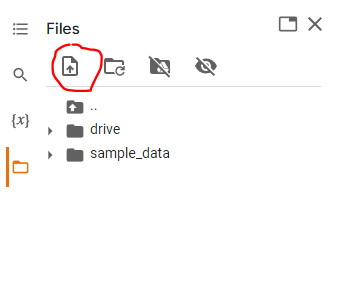

The envi.open call requires only the .hdr, but the .raw file should be in the same location with the same file name.

Now that we have the data loaded we can learn something about it.

984.05 2580.51
<class 'list'>
data shape is  (1834, 384, 288)


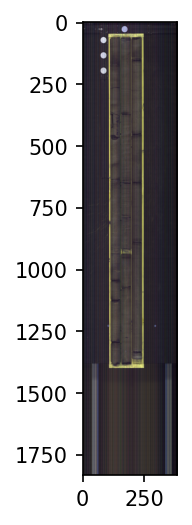

In [8]:
bands = data.bands.centers
print(bands[1], bands[-1])
print(type(bands))
print('data shape is ', data.shape)
view = sp.imshow(data)

Using the envi.open call reads all of the data from the header file and saves it as an attribute of the hyperspectral data object.

We have accessed the bands centers attribute and have it as an ordered list. Printing the first and last elements of the bands list shows us that the wavelength range of this camera is 984.05 - 2580.51nm.

The data shape describes the organisation of the data. In this case we can see it is a 3 dimensional array (M x N x B). If we think of the data as a hypercube where M is the number of pixels along the y-axis in plan view, N is the number of pixels along the x-axis in plan view and B is the number of bands along z-axis of the cube.

We can use the sp.imshow function to see the hyperspectral image. sp.imshow uses the default bands from the header for the R, G and B channels. You can also specify different bands as a keyword argument with a tuple if you wish.

We can interrogate the data further by plotting full spectrum from individual pixels. In this case M = 1000 and N = 220

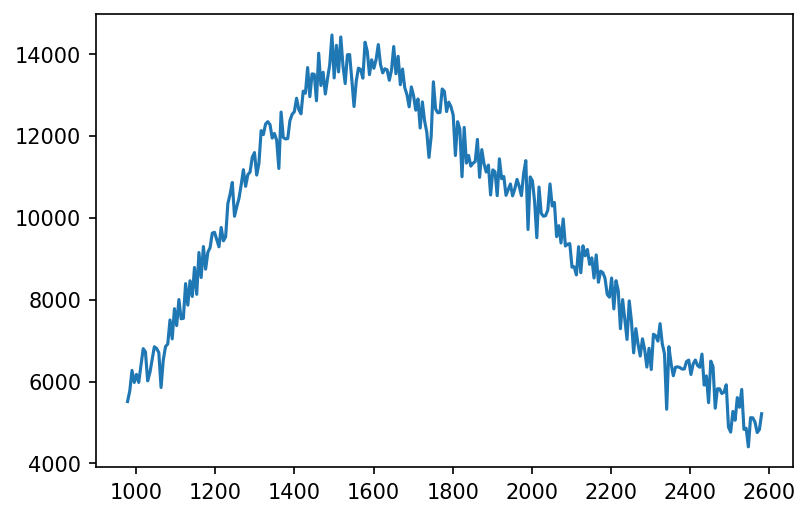

In [9]:
plt.figure()
plt.plot(bands, data[1000, 220])
plt.show()

As you can see from the spectra plot, this is radiance data, raw and needs to be corrected for reflectance.

All the GSI hyperspectral data comes with a white reference and a dark reference. The white reference is an image of spectralon, which is almost completely reflective in the SWIR wavelength range. The dark reference is an image taken with camera shutters closed to capture the electrical noise the instrument makes.

To calculate reflectance the equation is:

$$\frac{data - dark}{white - dark}$$


/usr/local/lib/python3.8/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


white shape  (283, 384, 288)
dark shape  (100, 384, 288)


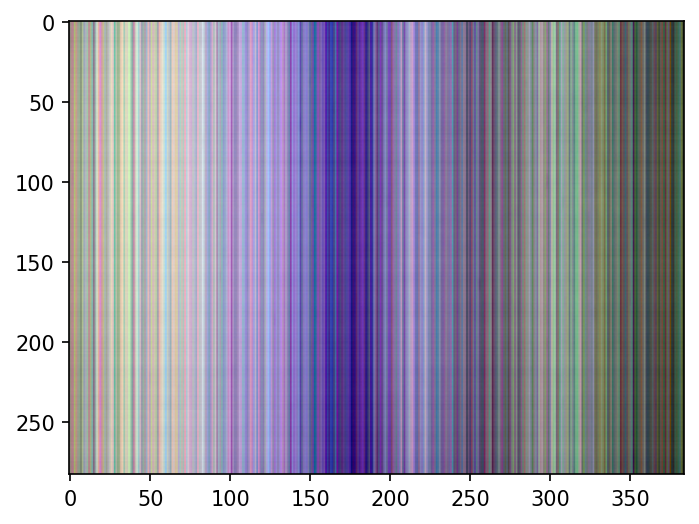

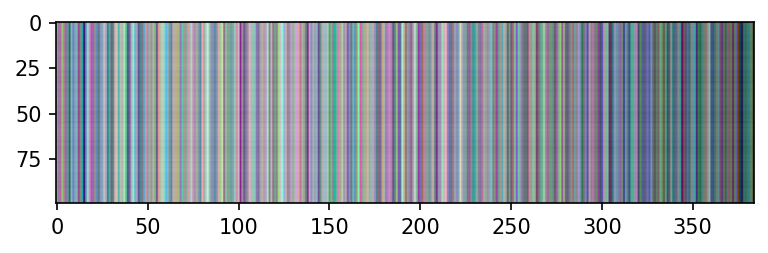

In [10]:
white = envi.open('/content/drive/MyDrive/Public/WHITEREF_17_7_BALLYBAUN_24_101m57_105m98_2022-10-07_10-53-37.hdr')
dark = envi.open('/content/drive/MyDrive/Public/DARKREF_17_7_BALLYBAUN_24_101m57_105m98_2022-10-07_10-53-37.hdr')
print('white shape ', white.shape)
print('dark shape ', dark.shape)
view1 = sp.imshow(white)
view2 = sp.imshow(dark)

It can be seen that the shapes of the white reference and dark reference are not the same as the data or as each other, but the vertical striping shows that they are consistent along the y- axis.
In order to perform mathematical operation on numpy arrays, the arrays need to be broadcastable, or have have at least 1 dimension with a common shape. 
More detail about numpy broadcasting can be found [here](https://numpy.org/doc/stable/user/basics.broadcasting.html).

To work with the all three arrays we must re-cast them as numpy arrays.

In [11]:
data_arr = np.array(data.load())
white_arr = np.array(white.load())
dark_arr = np.array(dark.load())

Now the white reference and dark reference must be made broadcastable with the data array.

In [12]:
white_arr = np.mean(white_arr, axis=0)
dark_arr = np.mean(dark_arr, axis=0)
print('New white shape ', white_arr.shape)
print('New dark shape ', dark_arr.shape)

New white shape  (384, 288)
New dark shape  (384, 288)


These lines have calculated the mean along the y-axis and produced a 2 dimensional array with the x-axis and band axis the same as the data x-axis and band axis.

We can now calculate reflectance

(1834, 384, 288)
(1834, 384, 288)
(1834, 384, 288)


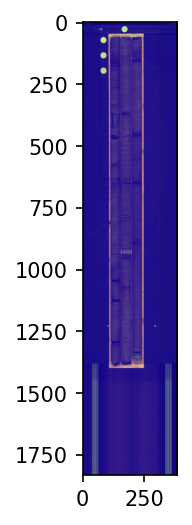

In [13]:
reflectance = np.divide(np.subtract(data_arr, dark_arr), np.subtract(white_arr, dark_arr))
print(data.shape)
print(data_arr.shape)
print(reflectance.shape)
view = sp.imshow(reflectance)

As you can see the reflectance data has the same shape as the original data, but the values are different.

Lets us again plot pixel (1000, 220)

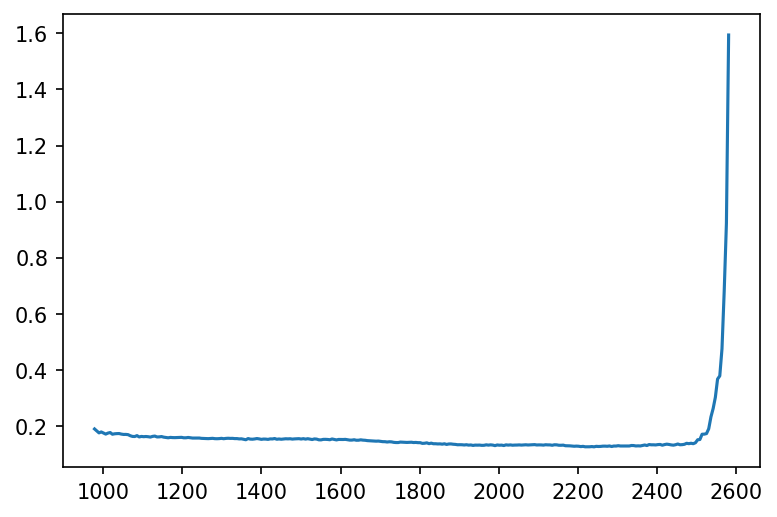

In [14]:
plt.figure()
plt.plot(bands, reflectance[1000, 220])
plt.show()

It can be seen that this still does not look like a mineral spectra.

In all instruments the bands at the edge of the range are the noisiest.

If we clip them out and again plot pixel (1000, 220)

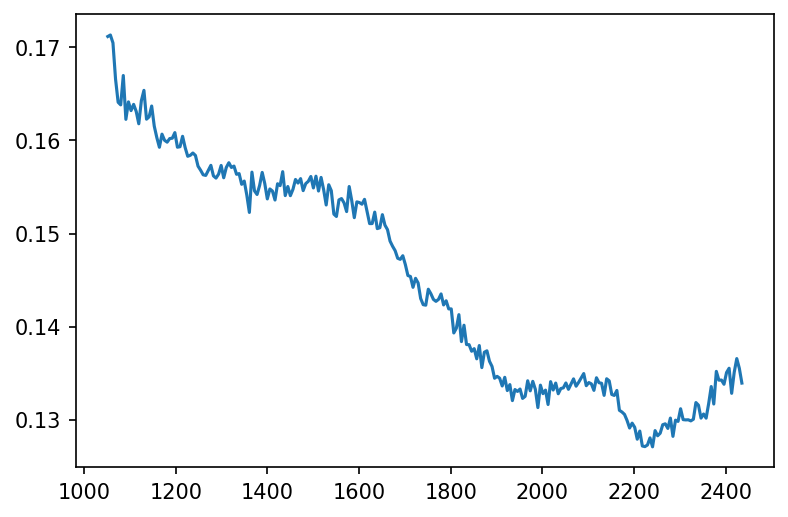

In [15]:
plt.figure()
plt.plot(bands[13:262], reflectance[1000, 220, 13:262])
plt.show()

We now have a core-box of reflectance corrected data and are ready to denoise it and begin the image processing.

Save the required files locally using the correct filepath for your machine:

In [ ]:
np.save('/content/drive/MyDrive/Public/Clipped_Bands.npy', bands[13:262])
np.save('/content/drive/MyDrive/Public/GSI_17_007_Bx24_reflectance.npy', reflectance[:, :, 13:262])